In [2]:
import xarray as xr
import numpy as np
import os

# 1. 路径设置 (保持你之前的路径)
file_path = r'../data_generators/dataset_yrd.nc'

# 2. 读取数据
ds = xr.open_dataset(file_path)

# --- A. 基础信息输出 ---
print("=== 维度信息 ===")
print(f"时间维度 (time): {ds.dims['time']}")
print(f"站点维度 (station): {ds.dims['station']}")

# 获取所有变量名 (PM2.5, O3, t2m, etc.)
var_names = list(ds.data_vars)
print(f"\n包含的变量: {var_names}")


# 如果你想把所有变量堆叠成一个大数组用于训练模型
all_data_list = []
for var in var_names:
    all_data_list.append(ds[var].values)

# stack 堆叠: axis=-1 表示在最后一个维度增加变量维
# 结果形状: (70128, 127, 10)
full_time_series_array = np.stack(all_data_list, axis=-1)

print(f"\n=== 最终合并的时间序列数组 ===")
print(f"Shape: {full_time_series_array.shape}")
print("含义: (时间步, 站点数, 特征变量数)")
print(f"其中特征顺序对应: {var_names}")

ds.close()

=== 维度信息 ===
时间维度 (time): 70128
站点维度 (station): 127

包含的变量: ['PM2.5', 'O3', 't2m', 'd2m', 'sp', 'tp', 'blh', 'msdwswrf', 'u100', 'v100']

=== 最终合并的时间序列数组 ===
Shape: (70128, 127, 10)
含义: (时间步, 站点数, 特征变量数)
其中特征顺序对应: ['PM2.5', 'O3', 't2m', 'd2m', 'sp', 'tp', 'blh', 'msdwswrf', 'u100', 'v100']


/var/folders/mw/53dhwskj4zq47dtls4lhht4m0000gn/T/ipykernel_91179/312109766.py:13: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"时间维度 (time): {ds.dims['time']}")
/var/folders/mw/53dhwskj4zq47dtls4lhht4m0000gn/T/ipykernel_91179/312109766.py:14: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"站点维度 (station): {ds.dims['station']}")


# 数据展示

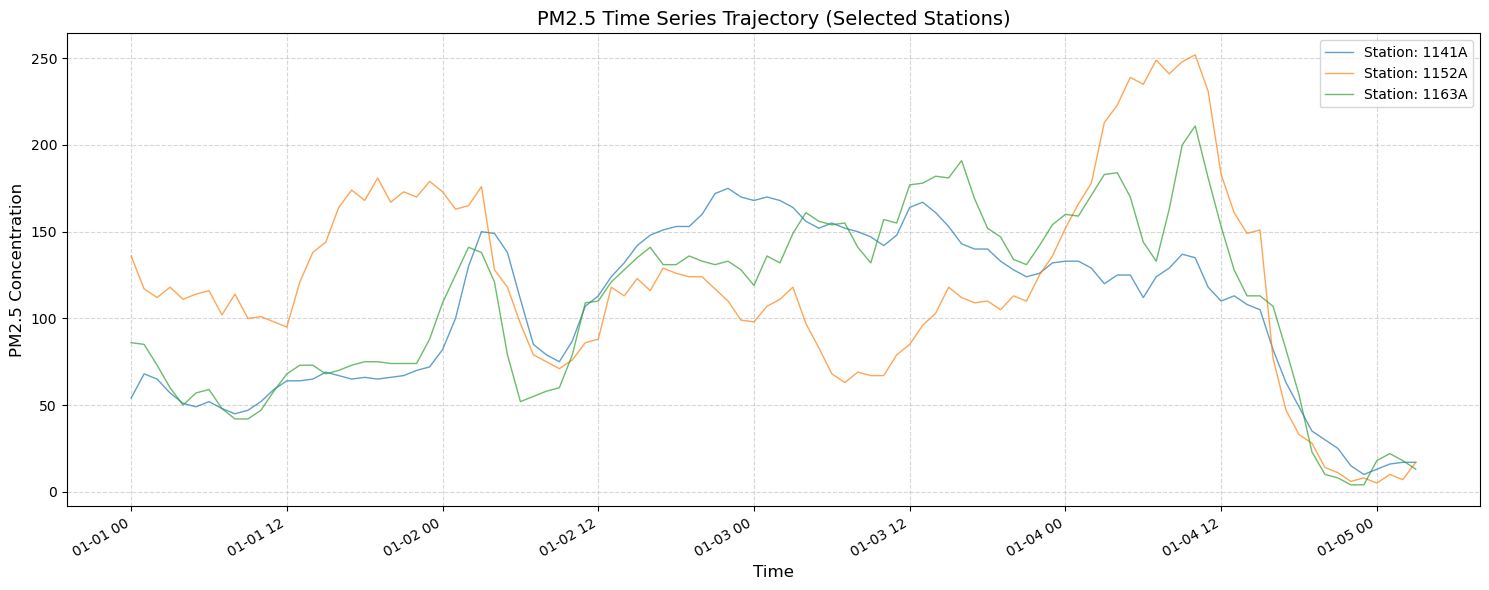

In [4]:
import matplotlib.pyplot as plt

num_stations_to_plot = 3
pm25 = ds['PM2.5']
times = ds['time'].values
stations = ds['station'].values
# 方式 A: 随机选择站点
# selected_indices = np.random.choice(len(stations), num_stations_to_plot, replace=False)

# 方式 B: 手动指定前几个站点 (比较稳定，适合观察)
selected_indices = [0, 10, 20] # 比如第1个、第11个、第21个站点

# 创建画布
plt.figure(figsize=(15, 6))

# 循环绘制选定站点的曲线
for idx in selected_indices:
    station_name = stations[idx]
    # 提取该站点的 PM2.5 数据
    # .isel(station=idx) 按索引取
    station_data = pm25.isel(station=idx).values
    
    plt.plot(times[:100], station_data[:100], label=f'Station: {station_name}', alpha=0.7, linewidth=1)

# 添加图表细节
plt.title('PM2.5 Time Series Trajectory (Selected Stations)', fontsize=14)
plt.ylabel('PM2.5 Concentration', fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)

# 优化时间轴显示 (防止重叠)
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

# 算法处理

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import scipy
import seaborn as sns
import sklearn
import pysindy as ps 
from sklearn.linear_model import Lasso
from tools import get_positive_contributions, compute_entropy, print_equations
from data_func import plot_clustered_kuramoto, generate_kuramoto_cluster_data_sin_cos
import warnings
from sklearn.exceptions import ConvergenceWarning

# 仅忽略收敛警告
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [6]:
x_data = pm25.values
x_data.shape

(70128, 127)

In [33]:
# 候选的观测函数
ide = ps.IdentityLibrary()
fourier = ps.FourierLibrary(n_frequencies=1)
ode_lib = ps.PolynomialLibrary(degree=2,include_bias=False)
library_functions = [
    lambda x: x,
    lambda x: np.sin(x),
    lambda x: np.cos(x),
]
custom_library = ps.CustomLibrary(library_functions=library_functions)

# 选定观测函数
library = ode_lib

# 进行lift
library.fit(x_data)
x_data_lift = library.transform(x_data)
names = library.get_feature_names()

# 单时间序列
print(x_data_lift.shape)
# 多时间序列
#print(x_data_lift[0].shape)
# 检查观测函数变量名
print(names)

(70128, 8255)
['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46', 'x47', 'x48', 'x49', 'x50', 'x51', 'x52', 'x53', 'x54', 'x55', 'x56', 'x57', 'x58', 'x59', 'x60', 'x61', 'x62', 'x63', 'x64', 'x65', 'x66', 'x67', 'x68', 'x69', 'x70', 'x71', 'x72', 'x73', 'x74', 'x75', 'x76', 'x77', 'x78', 'x79', 'x80', 'x81', 'x82', 'x83', 'x84', 'x85', 'x86', 'x87', 'x88', 'x89', 'x90', 'x91', 'x92', 'x93', 'x94', 'x95', 'x96', 'x97', 'x98', 'x99', 'x100', 'x101', 'x102', 'x103', 'x104', 'x105', 'x106', 'x107', 'x108', 'x109', 'x110', 'x111', 'x112', 'x113', 'x114', 'x115', 'x116', 'x117', 'x118', 'x119', 'x120', 'x121', 'x122', 'x123', 'x124', 'x125', 'x126', 'x0^2', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x0 x5', 'x0 x6', 'x0 x7', 'x0 x8',

In [34]:
# 离散的迭代方程 or 连续的微分方程
discrete_time=True
if discrete_time:
    dt = 1
else:
    dt = 1#np.array(range(x_data_lift.shape[0]))

# 候选拟合器
sr3_optimizer = ps.SR3(reg_weight_lam=0.05, regularizer="l2")
lasso_optimizer = Lasso(alpha=0.004, max_iter=20000, fit_intercept=True)
stlsq_optimizer = ps.STLSQ(threshold=0.01, alpha=0.9, verbose=False)

optimizer = stlsq_optimizer

# 进行拟合
model = ps.SINDy(feature_library=ide, optimizer=optimizer, discrete_time=discrete_time)
model.fit(x_data_lift, t=dt, feature_names=names)
model.print()

In [30]:
model.score(x_data_lift, t=dt)

0.9436542153997681

In [31]:
step_pred = 100
t = range(step_pred)
# 单时间序列
init_data = x_data_lift[0,:]
# 多时间序列
#init_data = x_data_lift[0][0,:]

if discrete_time:
    X_data_predicted = model.simulate(init_data,step_pred)
else:
    X_data_predicted = model.simulate(init_data,t) 

X_data_predicted.shape

(1000, 127)

/var/folders/mw/53dhwskj4zq47dtls4lhht4m0000gn/T/ipykernel_90570/2308130201.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


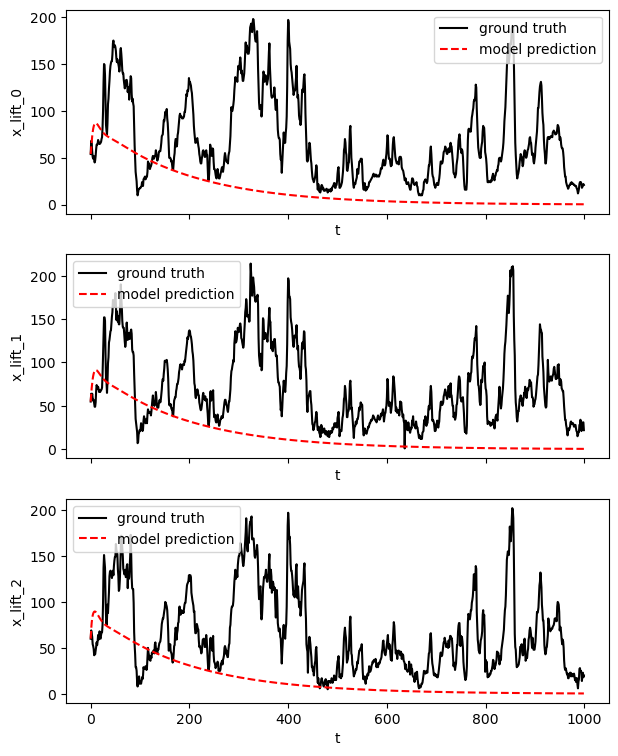

In [32]:
# 只看部分维度的多步预测
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(7, 9))
for i in range(3):
    axs[i].plot(x_data_lift[:step_pred, i], "k", label="ground truth")
    axs[i].plot(X_data_predicted[:step_pred, i], "r--", label="model prediction")
    axs[i].legend()
    axs[i].set(xlabel="t", ylabel=r"x_lift_{}".format(i))
fig.show()

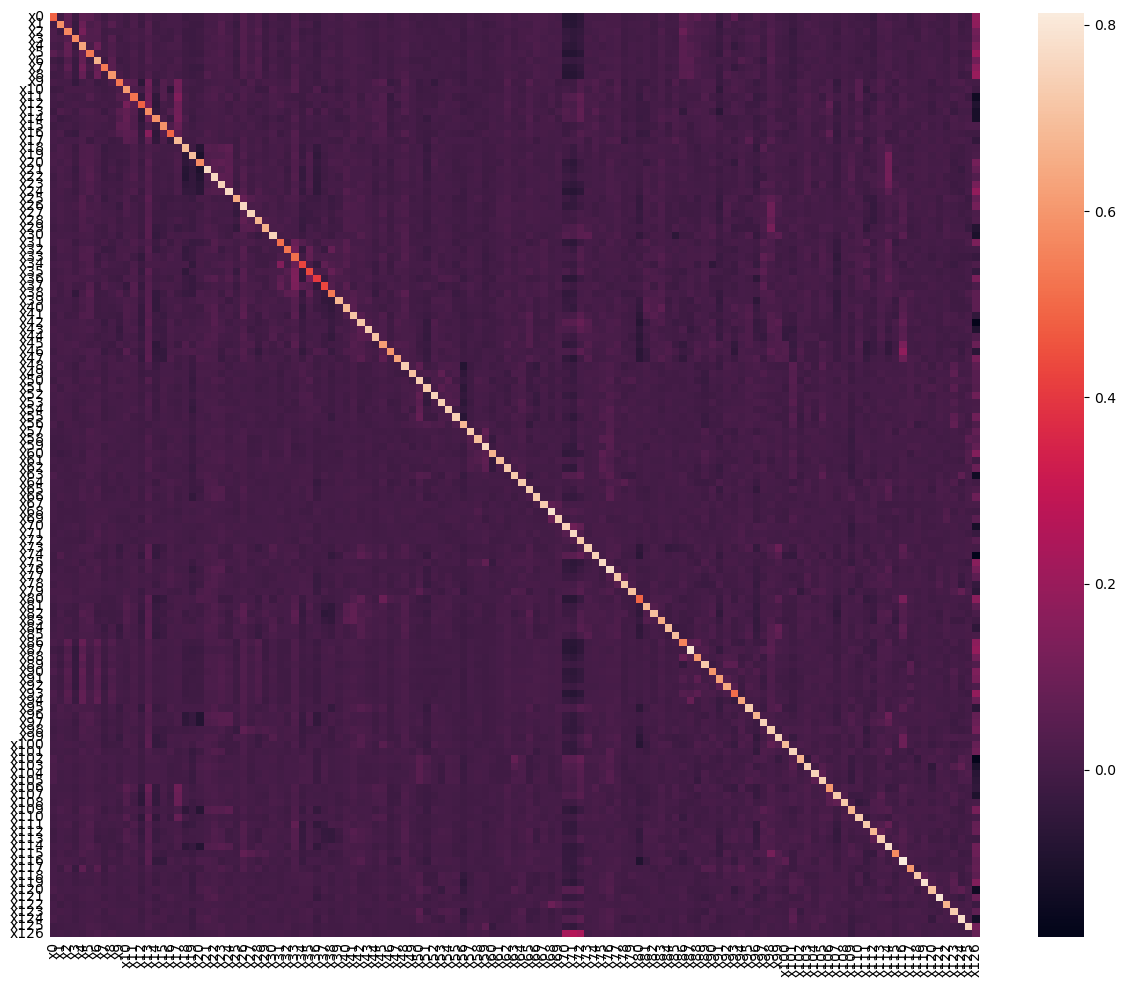

In [28]:
# 提取和处理系数矩阵
A = model.coefficients()
if discrete_time==False:
    A = scipy.linalg.expm(A)

# 只设置参数，不自动显示全部
plt.figure(figsize=(15, 12)) # 把画布搞大一点
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(A, xticklabels=names, yticklabels=names)
# 旋转横轴标签，避免重叠
plt.xticks(rotation=90)  # 旋转90度
plt.yticks(rotation=0)   # 纵轴保持水平
plt.show()